In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import contextily as ctx
import scipy.stats as stats
from shapely import Point

In [2]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')
dbi = gpd.read_feather('../data/dbi_permits.geofeather')
fees = gpd.read_file('../data/Neighborhood-Specific Impact Fee Areas.geojson')

## Fees

In [3]:
fees.loc[fees.tier.str.contains('Tier 1 if residential') == True, 'tier'] = 'Tier 1'
simplefees = fees[fees.tier.isin(['Tier 1', 'Tier 2'])] # , 'Tier 3'
simplefees = simplefees.dissolve('tier').reset_index()
simplefees = simplefees.to_crs(3310)
x_min, y_min, x_max, y_max = simplefees.total_bounds

<AxesSubplot: >

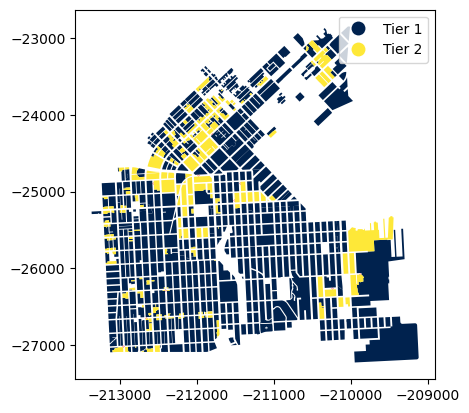

In [4]:
M = 1000
points = [Point(x, y) for x, y in zip(np.random.uniform(x_min, x_max, M), np.random.uniform(y_min, y_max, M))]

# Create a GeoDataFrame from the points
gdf_points = gpd.GeoDataFrame({'geometry': points})

# Calculate the distance from each point to each multipolygon
gdf_points['dist_to_poly1'] = gdf_points.distance(simplefees.geometry[0])
gdf_points['dist_to_poly2'] = gdf_points.distance(simplefees.geometry[1])

# Find points where the absolute difference in distance is within a tolerance of 25 meters
tolerance = 15
gdf_equidistant = gdf_points[(0 < gdf_points['dist_to_poly1']) &
                             (gdf_points['dist_to_poly1'] <= tolerance) &
                             (0 < gdf_points['dist_to_poly2']) & 
                             (gdf_points['dist_to_poly2'] <= tolerance)]

gdf_equidistant.shape[0]

ax = gdf_equidistant.plot(markersize=.05, c='red')
simplefees.plot(ax=ax, column='tier', legend=True, cmap='cividis')

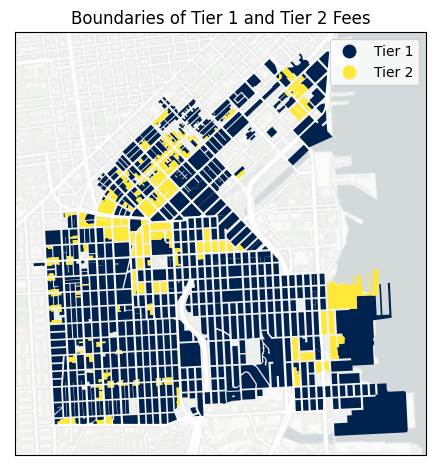

In [5]:
ax = simplefees.plot(column='tier', legend=True, cmap='cividis')
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=3310)
ax.set_title('Boundaries of Tier 1 and Tier 2 Fees')
plt.tight_layout()
plt.savefig('tier1_tier2_boundaries.png')

## Permits

In [6]:
panel = gpd.read_feather('../data/basic_panel.geofeather')

In [7]:
panel = panel.cx[x_min:x_max, y_min:y_max]

In [8]:
cross_section = panel[panel.year == 2014]

In [9]:
y = panel[panel.year >= 2014].groupby("MapBlkLot_Master")['Net_Units_Completed'].sum()

In [10]:
cross_section = pd.merge(cross_section.drop(columns='Net_Units_Completed'),
                         y.reset_index(),
                         on='MapBlkLot_Master')

In [11]:
cross_section.Net_Units_Completed.sum()

7153.0

In [12]:
cross_section = cross_section.drop(columns=['mapblklot', 'permit_number', 'year'])

In [13]:
cross_section['tier1'] = cross_section.geometry.intersects(simplefees.iloc[0].geometry)
cross_section['tier2'] = cross_section.geometry.intersects(simplefees.iloc[1].geometry)

## Take the subset of the data where there are fees

In [14]:
east_homes = cross_section[(cross_section['tier1'] ^ cross_section['tier2'])].copy()
east_homes['tier'] = 'tier2'
east_homes.loc[east_homes['tier1'], 'tier'] = 'tier1'

In [15]:
east_homes['dist_to_tier1'] = east_homes.geometry.centroid.distance(simplefees.geometry.iat[0])
east_homes['dist_to_tier2'] = east_homes.geometry.centroid.distance(simplefees.geometry.iat[1])
east_homes['dist_to_boundary'] = np.maximum(east_homes['dist_to_tier1'], east_homes['dist_to_tier2'])
east_homes['dist_to_boundary'] = east_homes['dist_to_boundary'] * ((-1)**(east_homes['tier'] == 'tier2'))

In [16]:
boundary_homes = east_homes[(np.absolute(east_homes['dist_to_boundary']) < 200)].copy()

In [17]:
boundary_homes.Developed = boundary_homes.Net_Units_Completed > 0

In [18]:
boundary_homes.Net_Units_Completed.mean()

0.3725461035098156

In [19]:
boundary_homes.Net_Units_Completed.var()

52.355462146468525

## Comparing Boundaries

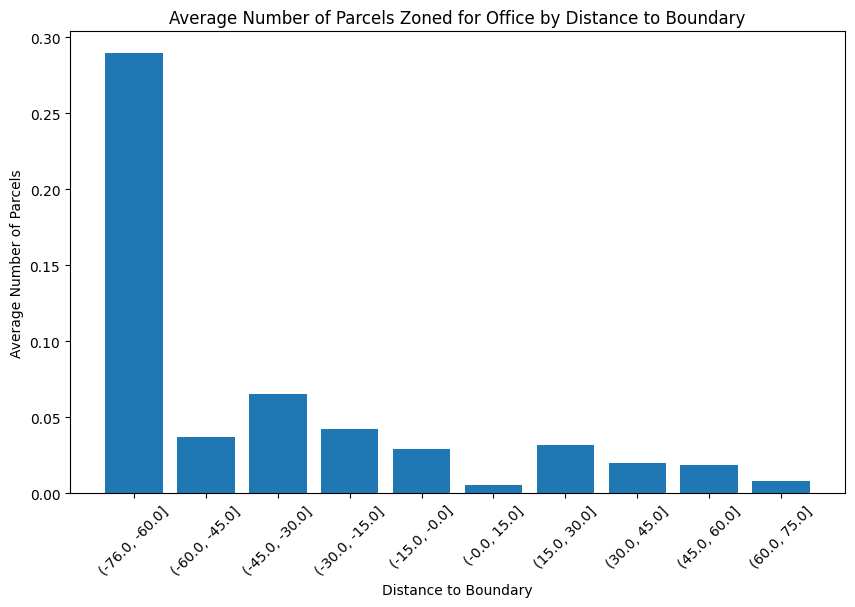

In [20]:
df = boundary_homes[(np.absolute(boundary_homes['dist_to_boundary']) <= 75)].copy()
bin_edges = np.linspace(df['dist_to_boundary'].min(), df['dist_to_boundary'].max(), 11)
df['dist_to_boundary_bin'] = pd.cut(df['dist_to_boundary'], bins=bin_edges, include_lowest=True, precision=0)

# Calculate the average number of observations where 'zp_OfficeComm' is True
grouped_df = df.groupby('dist_to_boundary_bin').apply(lambda x: x['zp_OfficeComm'].mean())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(grouped_df.index.astype(str), grouped_df.values)
plt.xlabel('Distance to Boundary')
plt.ylabel('Average Number of Parcels')
plt.title('Average Number of Parcels Zoned for Office by Distance to Boundary')
plt.xticks(rotation=45)
plt.savefig('office_zoning_boundary.png')

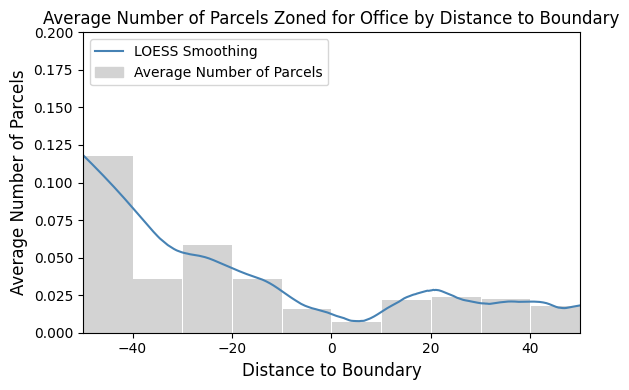

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D

# Preparing the data
df = boundary_homes[(np.absolute(boundary_homes['dist_to_boundary']) <= 75)].copy()
bin_edges = np.linspace(df['dist_to_boundary'].min(), df['dist_to_boundary'].max(), 11)
df['dist_to_boundary_bin'] = pd.cut(df['dist_to_boundary'], bins=bin_edges, include_lowest=True, precision=0)

# Grouping data
grouped_df = df.groupby('dist_to_boundary_bin').apply(lambda x: x['zp_OfficeComm'].mean()).reset_index()

# Prepare data for LOESS
x = df['dist_to_boundary'].values
y = df['zp_OfficeComm'].astype(int).values

# Fit LOESS model
lowess_results = sm.nonparametric.lowess(y, x, frac=0.25, it=0, delta=.1) 

# Generate new data for predictions
lower_bound = -50
upper_bound = 50
x_pred = np.linspace(0, upper_bound, 100)

# Calculate mean value for each bucket
bucket_width = 10
buckets = np.arange(lower_bound, upper_bound, bucket_width)
mean_values_per_bucket = [df[(df['dist_to_boundary'] >= left) & 
                             (df['dist_to_boundary'] < left + bucket_width)]['zp_OfficeComm'].mean() 
                          for left in buckets]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lowess_results[:, 0], 
         np.maximum(lowess_results[:, 1], np.zeros_like(lowess_results[:, 1].flatten())), 
         label='Predicted probabilities', color='steelblue')

# Add vertical bars
for i, left in enumerate(buckets):
    mean_val = mean_values_per_bucket[i]
    if mean_val is not np.nan:
        plt.bar(left + 5.1, mean_val, facecolor='lightgrey', width=bucket_width * .98)

# Legend
plt.legend(handles=[Line2D([0], [0], linestyle='-', color='steelblue', 
                           label='LOESS Smoothing', markersize=10),
                    Patch(color='lightgrey', label='Average Number of Parcels')], loc='upper left')

# Labels and Title
plt.xlabel('Distance to Boundary', fontsize=12)
plt.xlim((-50, 50))
plt.ylim((0, .2))
plt.ylabel('Average Number of Parcels', fontsize=12)
plt.title('Average Number of Parcels Zoned for Office by Distance to Boundary')

# Save the plot
plt.tight_layout()
plt.savefig('office_zoning_boundary.png', bbox_inches='tight')

# Show the plot
plt.show()


In [47]:
df['dist_to_boundary'].min()

-74.98937747157868

In [29]:
grouped_df.dist_to_boundary_bin[0]

Interval(-76.0, -60.0, closed='right')

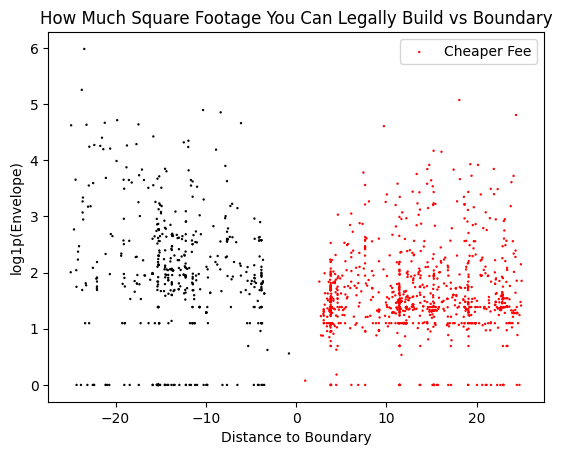

In [187]:
df = boundary_homes[(np.absolute(boundary_homes['dist_to_boundary']) <= 25)].copy()

plt.scatter(df['dist_to_boundary'],
            np.log1p(df['Envelope_1000']), alpha=1, s=.5,
            c=df['tier'].map(color_map))
plt.legend(['Cheaper Fee', 'Expensive Fee'])
plt.title('How Much Square Footage You Can Legally Build vs Boundary')
plt.xlabel('Distance to Boundary')
plt.ylabel('log1p(Envelope)')
plt.savefig('Envelope_boundary.png')

## Permits

In [44]:
boundary_homes.to_feather('../data/clean_fees_rdd.feather')

In [45]:
boundary_homes.to_csv('../data/clean_fees_rdd.csv')

## Confirm upzonings can be controlled for by 2010

In [ ]:
upzonings = parcels.pivot(index='MapBlkLot_Master', columns='year', values='Upzone_Ratio')
upzonings = upzonings.diff(axis=1).iloc[:, 1:-1]

In [ ]:
plot_upzoning = pd.merge(allParcels[['mapblklot', 'geometry']].drop_duplicates(),
                         upzonings,
                         right_index=True, 
                         left_on='mapblklot')

In [ ]:
simplefees = simplefees.to_crs(3857)
min_x, min_y, max_x, max_y = simplefees.total_bounds

In [ ]:
plot_upzoning = plot_upzoning.to_crs(3857)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
year = 2010
plot_upzoning[['geometry', year]][plot_upzoning[year] > 0].plot(ax=ax, column=year, legend=True)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)

In [ ]:
plot_upzoning['tier1'] = plot_upzoning.geometry.intersects(simplefees.iloc[0].geometry)
plot_upzoning['tier2'] = plot_upzoning.geometry.intersects(simplefees.iloc[1].geometry)

In [ ]:
eastern_upzonings = plot_upzoning[plot_upzoning.tier1 | plot_upzoning.tier2]

In [ ]:
eastern_upzonings

In [ ]:
drop_nan = eastern_upzonings[~eastern_upzonings.isna().any(axis=1)]

In [ ]:
corr_coefficient, p_value = stats.spearmanr(drop_nan[2010], drop_nan['tier2'])
corr_coefficient

In [ ]:
corr_coefficient, p_value = stats.spearmanr(drop_nan[2011], drop_nan['tier2'])
corr_coefficient